# Property Price Prediction

This project predicts property prices using machine learning models. It covers data loading, preprocessing, model training, and evaluation.

## 1. Import Libraries

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

## 2. Load Dataset

In [2]:
# Load Dataset

df = pd.read_csv(r"C:\Users\dell\Downloads\data_science_challenge_data.csv")

## 3. Data Exploration

In [9]:
# Basic Exploration

print('---------------------- Available information ----------------------')
print(df.head(), "\n")

print('---------------- check Datatype ----------------')
print(df.info(), "\n")

print('-------------- count null value --------------')
print(df.isnull().sum(), "\n")

print('---------------- with outlier ----------------')
print(df[['size','price']].describe(),"\n")
print('--- skewness of feature ---')
print(df.skew(), "\n")

---------------------- Available information ----------------------
  neighbourhood     price    size  bedrooms  bathrooms      building
0           SNR  130000.0  1300.0         2        3.0  Building_263
1           ZMS  140000.0  1185.0         1        2.0   Building_25
2           ZMS  250000.0  2050.0         3        5.0  Building_324
3           ZMS  250000.0  3860.0         4        5.0  Building_353
4           SNR  170000.0  1896.0         3        4.0  Building_280 

---------------- check Datatype ----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67107 entries, 0 to 67106
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   neighbourhood  67107 non-null  object 
 1   price          67107 non-null  float64
 2   size           67107 non-null  float64
 3   bedrooms       67107 non-null  int64  
 4   bathrooms      63657 non-null  float64
 5   building       61068 non-null  object 
dtypes:

C:\Users\dell\AppData\Local\Temp\ipykernel_11576\1520252326.py:15: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.skew(), "\n")


# 4.Cleaning

In [10]:
# Data Cleaning

df = df[df['size'] > 0]
df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].median())
df['building'] = df['building'].fillna('unknown')

df['building'] = df['building'].str.strip().str.lower()
df['building_code'] = df['building'].astype('category').cat.codes

df['neighbourhood'] = df['neighbourhood'].str.strip().str.lower()
df['neighbourhood_code'] = df['neighbourhood'].astype('category').cat.codes

In [14]:
# ---------------- EDA: Remove Outliers for Visualization ----------------
df_eda = df.copy()
size_thresh = df_eda['size'].quantile(0.99)
price_thresh = df_eda['price'].quantile(0.99)
df_eda = df_eda[(df_eda['size'] <= size_thresh) & (df_eda['price'] <= price_thresh)]


print('--------- without outlier ---------')
print(df_eda[['size','price']].describe(),"\n")
print('----- skewness of feature -----')
print(df_eda.skew(), "\n")

--------- without outlier ---------
               size          price
count  66069.000000   66069.000000
mean    1316.430786  138802.708152
std      727.728677   56903.564856
min        1.000000   22000.000000
25%      833.000000   98000.000000
50%     1200.000000  130000.000000
75%     1600.000000  165000.000000
max     6500.000000  610000.000000 

----- skewness of feature -----
price                 1.768379
size                  2.057254
bedrooms              0.385942
bathrooms             0.809275
building_code         0.081272
neighbourhood_code   -0.444982
dtype: float64 



C:\Users\dell\AppData\Local\Temp\ipykernel_11576\559337847.py:11: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df_eda.skew(), "\n")


## 5. EDA Visualizations

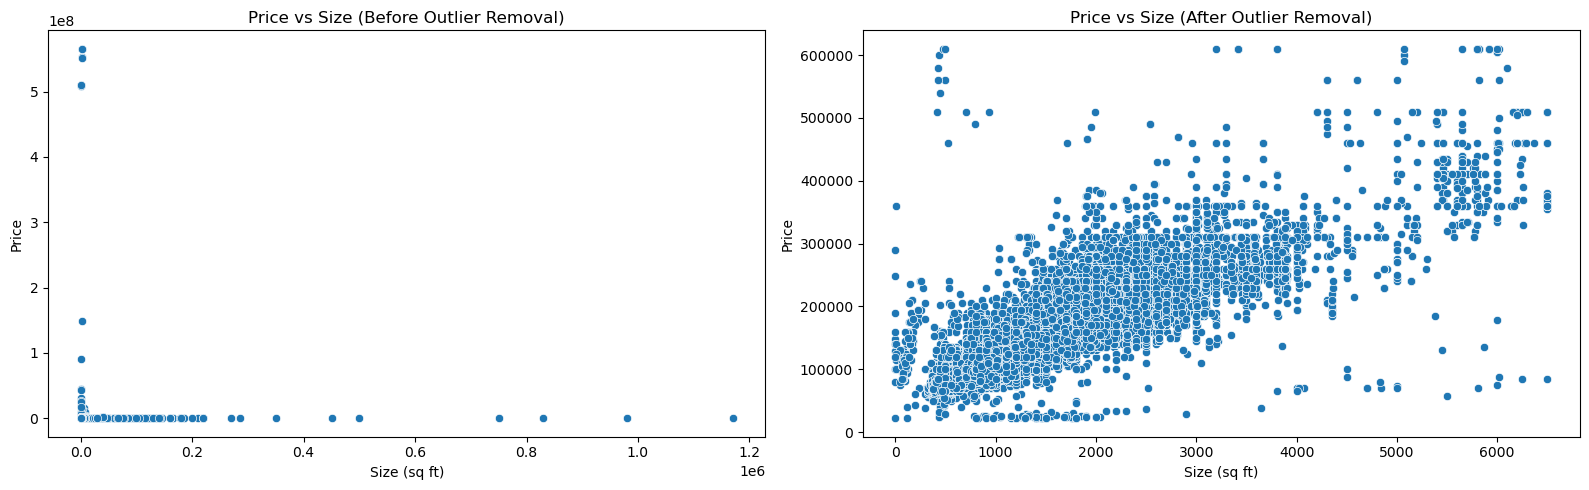

In [15]:
# ---------------- EDA Visualizations ----------------
fig, axes = plt.subplots(1, 2, figsize=(16, 5))  # 1 row, 2 columns

# Before Outlier Removal
sns.scatterplot(data=df, x='size', y='price', ax=axes[0])
axes[0].set_title('Price vs Size (Before Outlier Removal)')
axes[0].set_xlabel('Size (sq ft)')
axes[0].set_ylabel('Price')

# After Outlier Removal
sns.scatterplot(data=df_eda, x='size', y='price', ax=axes[1])
axes[1].set_title('Price vs Size (After Outlier Removal)')
axes[1].set_xlabel('Size (sq ft)')
axes[1].set_ylabel('Price')

plt.tight_layout()
plt.show()

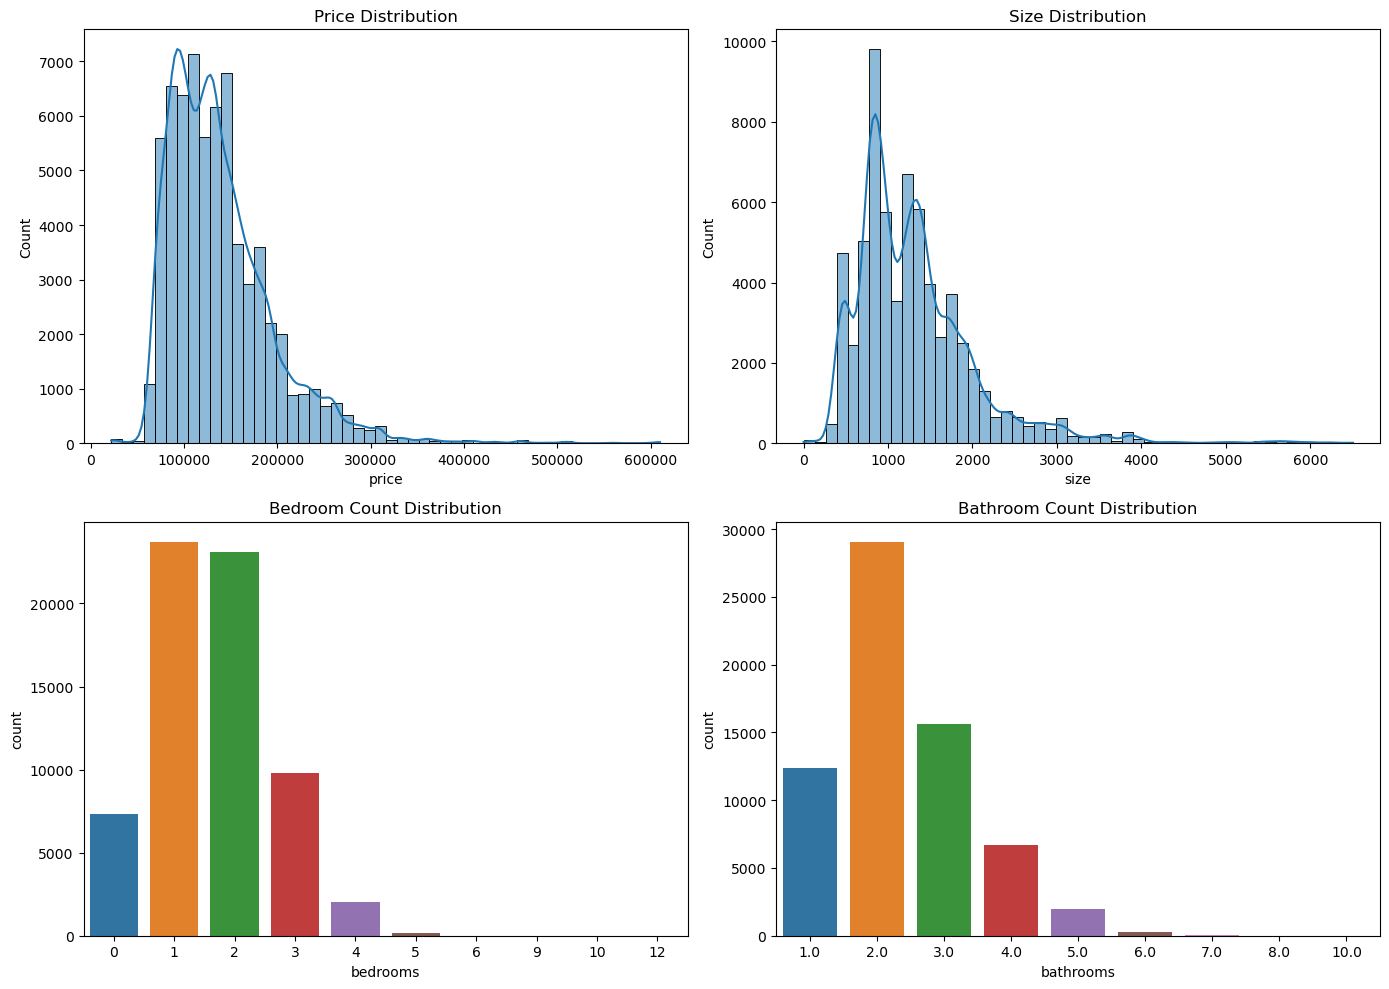

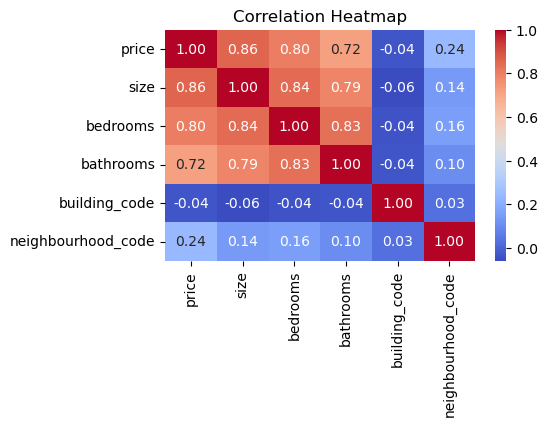

In [16]:
#price and size distribution
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
sns.histplot(df_eda['price'], bins=50, kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Price Distribution')
sns.histplot(df_eda['size'], bins=50, kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Size Distribution')

#count of bedrooms and bathrooms
sns.countplot(x='bedrooms', data=df_eda, ax=axs[1, 0])
axs[1, 0].set_title('Bedroom Count Distribution')
sns.countplot(x='bathrooms', data=df_eda, ax=axs[1, 1])
axs[1, 1].set_title('Bathroom Count Distribution')

plt.tight_layout()
plt.show()

#heatmap
plt.figure(figsize=(5,3))
sns.heatmap(df_eda.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# 6.Feature Engineering and splitting

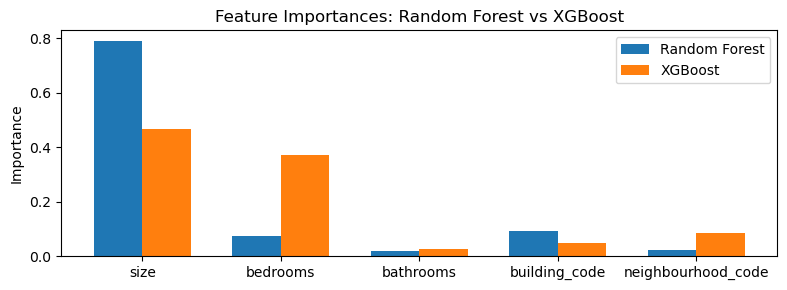

In [17]:
# ---------------- Feature Importance ----------------

df['log_price'] = np.log1p(df['price'])
X_temp = df[['size', 'bedrooms', 'bathrooms', 'building_code', 'neighbourhood_code']]
y_temp = df['log_price']

rf_temp = RandomForestRegressor(random_state=42)
rf_temp.fit(X_temp, y_temp)
rf_importances = rf_temp.feature_importances_

xgb_temp = XGBRegressor(random_state=42)
xgb_temp.fit(X_temp, y_temp)
xgb_importances = xgb_temp.feature_importances_

plt.figure(figsize=(8, 3))
x = np.arange(len(X_temp.columns))
bar_width = 0.35
plt.bar(x - bar_width/2, rf_importances, width=bar_width, label='Random Forest')
plt.bar(x + bar_width/2, xgb_importances, width=bar_width, label='XGBoost')
plt.xticks(x, X_temp.columns)
plt.title('Feature Importances: Random Forest vs XGBoost')
plt.ylabel('Importance')
plt.legend()
plt.tight_layout()
plt.show()

## 7. Model Training

In [18]:
# ---------------- Modeling using All Features ----------------

X = df[['size', 'bedrooms', 'bathrooms', 'building_code', 'neighbourhood_code']]
y = df['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

y_preds = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_preds[name] = model.predict(X_test)

## 8. Model Evaluation

               Model       MAE      RMSE  R2 Score
0  Linear Regression  0.155108  0.261803  0.638023
1      Random Forest  0.081329  0.212678  0.761121
2      Decision Tree  0.084829  0.231993  0.715764
3  Gradient Boosting  0.105240  0.211431  0.763916
4            XGBoost  0.084447  0.208636  0.770115


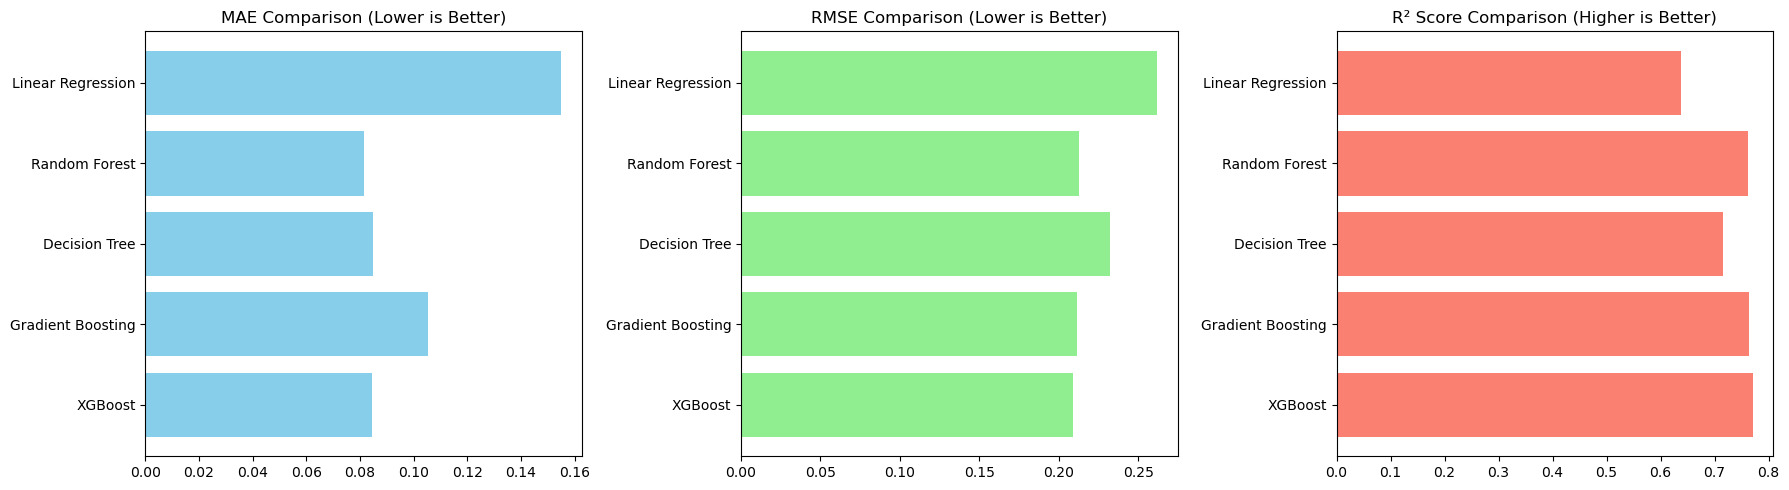

In [19]:
# Evaluation

def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return [model_name, mae, rmse, r2]

results = []
for name, preds in y_preds.items():
    results.append(evaluate_model(y_test, preds, name))

results_df = pd.DataFrame(results, columns=['Model', 'MAE', 'RMSE', 'R2 Score'])
print(results_df)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].barh(results_df['Model'], results_df['MAE'], color='skyblue')
axes[0].set_title('MAE Comparison (Lower is Better)')
axes[0].invert_yaxis()
axes[1].barh(results_df['Model'], results_df['RMSE'], color='lightgreen')
axes[1].set_title('RMSE Comparison (Lower is Better)')
axes[1].invert_yaxis()
axes[2].barh(results_df['Model'], results_df['R2 Score'], color='salmon')
axes[2].set_title('R² Score Comparison (Higher is Better)')
axes[2].invert_yaxis()
plt.tight_layout()
plt.show()

In [24]:
# Evaluate each model on both train and test sets
train_test_results = []

for name, model in models.items():
    
    model.fit(X_train, y_train)
    
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    # Calculate R2 scores
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)
    
    train_test_results.append([name, train_r2*100,test_r2*100])
# Convert results to DataFrame for better visualization
train_test_results_df = pd.DataFrame(train_test_results, columns=['Model', 'Train R²', 'Test R²'])

# Print the results
print('---------------- compare train vs test scores ----------------')
print(train_test_results_df)
print("\n")
print("We selected the XGBoost Regressor as the final model because it consistently outperformed others in  MAE, RMSE, and R². \n", 
"This made it the ideal choice for accurate property price prediction.")

print("\n")

---------------- compare train vs test scores ----------------
               Model   Train R²    Test R²
0  Linear Regression  59.633227  63.802344
1      Random Forest  84.233664  76.112148
2      Decision Tree  85.327509  71.576387
3  Gradient Boosting  72.333405  76.391644
4            XGBoost  79.309859  77.011550


We selected the XGBoost Regressor as the final model because it consistently outperformed others in  MAE, RMSE, and R². 
 This made it the ideal choice for accurate property price prediction.




## 9. Conclusion

In [22]:
# Property Valuation Tool
def property_valuation_tool(property_features, actual_price, model):
    predicted_log_price = model.predict([property_features])[0]
    predicted_price = np.expm1(predicted_log_price)
    lower_bound = predicted_price * 0.90
    upper_bound = predicted_price * 1.10

    if actual_price < lower_bound:
        return "Underpriced"
    elif actual_price > upper_bound:
        return "Overpriced"
    else:
        return "Fairly Priced"

# Example usage with all 5 features
sample_property = [1500, 2, 2, 12, 5]  # size, bedrooms, bathrooms, building_code, neighbourhood_code
actual_price = 140000
valuation = property_valuation_tool(sample_property, actual_price, models['XGBoost'])
print(f"Property Valuation Result: {valuation}")

Property Valuation Result: Underpriced
